# Gold & Diamond Weight Estimation Model

This notebook implements a multi-modal ML model to estimate Gold Weight and Diamond Weight.
It uses a custom DataGenerator to handle large datasets efficiently.

In [2]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [6]:
# --- Configuration ---
DATASET_DIR = "dataset_ring"
CSV_FILE = os.path.join(DATASET_DIR, "data_with_images.csv")
MODEL_SAVE_PATH = "gold_diamond_estimator.h5"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15

In [8]:
def clean_weight(val):
    if isinstance(val, str):
        val = val.lower().replace(" g", "").replace(" ct", "").replace("carat", "").strip()
        try:
            return float(val)
        except ValueError:
            return None
    return val

def load_and_clean_data():
    print(f"Loading data from {CSV_FILE}...")
    if not os.path.exists(CSV_FILE):
        raise FileNotFoundError(f"{CSV_FILE} not found. Run prepare_csv.py first.")
        
    df = pd.read_csv(CSV_FILE)
    
    # Filter rows with local images
    if 'LocalImage' not in df.columns:
        raise ValueError("LocalImage column missing.")
        
    df = df.dropna(subset=['LocalImage', 'Gold Weight', 'Diamond Weight'])
    
    # Process weights
    df['GoldWeight'] = df['Gold Weight'].apply(clean_weight)
    df['DiamondWeight'] = df['Diamond Weight'].apply(clean_weight)
    
    df = df.dropna(subset=['GoldWeight', 'DiamondWeight'])
    
    print(f"Total valid samples: {len(df)}")
    return df

In [9]:
# Load Data
df = load_and_clean_data()

# Prepare Purity Encoder
purity_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
purity_features = purity_encoder.fit_transform(df[['Purity']].astype(str))

print(f"Purity categories: {purity_encoder.categories_}")

Loading data from dataset_ring/data_with_images.csv...
Total valid samples: 2262
Purity categories: [array(['14K', '18K', '9K'], dtype=object)]


In [10]:
class GoldDiamondGenerator(Sequence):
    def __init__(self, df, purity_features, image_dir, batch_size=32, img_size=(224,224), shuffle=True):
        self.df = df.reset_index(drop=True)
        self.purity_features = purity_features
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        curr_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        batch_df = self.df.iloc[curr_indices]
        
        X_img = []
        X_tab = self.purity_features[curr_indices]
        y = batch_df[['GoldWeight', 'DiamondWeight']].values
        
        for _, row in batch_df.iterrows():
            img_path = os.path.join(self.image_dir, row['LocalImage'])
            try:
                img = load_img(img_path, target_size=self.img_size)
                img_arr = img_to_array(img) / 255.0
                X_img.append(img_arr)
            except Exception as e:
                # Fallback
                X_img.append(np.zeros((self.img_size[0], self.img_size[1], 3)))
                
        return (np.array(X_img), X_tab), y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

In [11]:
# Split Data indices
indices = np.arange(len(df))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=42)

train_df = df.iloc[train_idx]
val_df = df.iloc[val_idx]

train_purity = purity_features[train_idx]
val_purity = purity_features[val_idx]

print(f"Train samples: {len(train_df)}")
print(f"Val samples: {len(val_df)}")

# Create Generators
train_gen = GoldDiamondGenerator(train_df, train_purity, DATASET_DIR, BATCH_SIZE, IMG_SIZE)
val_gen = GoldDiamondGenerator(val_df, val_purity, DATASET_DIR, BATCH_SIZE, IMG_SIZE, shuffle=False)

Train samples: 1809
Val samples: 453


In [12]:
def build_model(num_purity_features):
    # Image Branch
    input_img = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3), name="image_input")
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_img)
    # Freeze base model layers (optional, unfreeze for fine-tuning later)
    for layer in base_model.layers:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    
    # Purity Branch
    input_purity = Input(shape=(num_purity_features,), name="purity_input")
    y = Dense(32, activation='relu')(input_purity)
    
    # Fusion
    combined = Concatenate()([x, y])
    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.2)(z)
    
    # Output
    output = Dense(2, activation='linear', name="output")(z)
    
    model = Model(inputs=[input_img, input_purity], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [13]:
model = build_model(num_purity_features=purity_features.shape[1])
model.summary()

/var/folders/bd/4_hz92g94l111ddpvj9_p64c0000gn/T/ipykernel_40558/3680520133.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_img)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,432,514 (9.28 MB)

 Trainable params: 174,530 (681.76 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
# Train
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

/Users/deepanshbhatia/Desktop/Gold estimation model/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - loss: 2.6291 - mae: 1.0775

/Users/deepanshbhatia/Desktop/Gold estimation model/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 370ms/step - loss: 1.6615 - mae: 0.8641 - val_loss: 0.8990 - val_mae: 0.6700
Epoch 2/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 351ms/step - loss: 0.9609 - mae: 0.6610 - val_loss: 0.6609 - val_mae: 0.5552
Epoch 3/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - loss: 0.7645 - mae: 0.5906 - val_loss: 0.6063 - val_mae: 0.5225
Epoch 4/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 360ms/step - loss: 0.5848 - mae: 0.5164 - val_loss: 0.5612 - val_mae: 0.5414
Epoch 5/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 359ms/step - loss: 0.4797 - mae: 0.4821 - val_loss: 0.5084 - val_mae: 0.4802
Epoch 6/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - loss: 0.4451 - mae: 0.4701 - val_loss: 0.4461 - val_mae: 0.4310
Epoch 7/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - loss: 0.3610 - mae: 0.4276 - val_loss: 0.4004 - val_mae: 0.4504
Epoch 8/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 366ms/step - loss: 0.2956 - mae: 0.3853 - val_loss: 0.3188 - val_mae: 0.3647
Epoch 9/15
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 381ms/step - loss

Evaluating on Validation Set...
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 261ms/step - loss: 0.2545 - mae: 0.3062
Validation MAE: 0.3062
Generating predictions...
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 269ms/step
R2 Score - Gold: 0.8477
R2 Score - Diamond: 0.8657
Gold Accuracy (within 0.5g): 79.25%
Diamond Accuracy (within 0.1ct): 27.37%


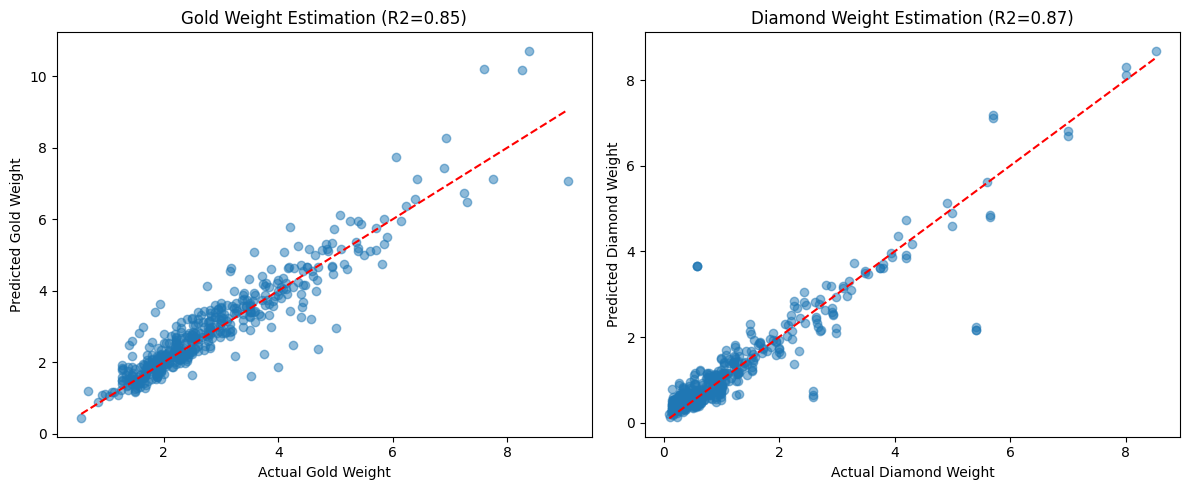

In [17]:
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# --- Evaluation ---
print("Evaluating on Validation Set...")
val_loss, val_mae = model.evaluate(val_gen)
print(f"Validation MAE: {val_mae:.4f}")


# Predictions
print("Generating predictions...")
y_pred = model.predict(val_gen)

# Get True Values aligned with Generator
y_true_list = []
# Iterate through generator manually to get batches in order to match predictions
for i in range(len(val_gen)):
    _, batch_y = val_gen[i]
    y_true_list.append(batch_y)
y_true = np.concatenate(y_true_list, axis=0)

# Slice y_pred to match y_true length if needed
y_pred = y_pred[:len(y_true)]

# Separate Gold and Diamond
gold_true = y_true[:, 0]
gold_pred = y_pred[:, 0]
dia_true = y_true[:, 1]
dia_pred = y_pred[:, 1]

# R2 Score
r2_gold = r2_score(gold_true, gold_pred)
r2_dia = r2_score(dia_true, dia_pred)

print(f"R2 Score - Gold: {r2_gold:.4f}")
print(f"R2 Score - Diamond: {r2_dia:.4f}")

# Accuracy Metric (Tolerance based)
def get_accuracy(true, pred, tolerance):
    return np.mean(np.abs(true - pred) <= tolerance) * 100

acc_gold_05 = get_accuracy(gold_true, gold_pred, 0.5)
acc_dia_01 = get_accuracy(dia_true, dia_pred, 0.1)

print(f"Gold Accuracy (within 0.5g): {acc_gold_05:.2f}%")
print(f"Diamond Accuracy (within 0.1ct): {acc_dia_01:.2f}%")

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(gold_true, gold_pred, alpha=0.5)
plt.plot([gold_true.min(), gold_true.max()], [gold_true.min(), gold_true.max()], "r--")
plt.xlabel("Actual Gold Weight")
plt.ylabel("Predicted Gold Weight")
plt.title(f"Gold Weight Estimation (R2={r2_gold:.2f})")

plt.subplot(1, 2, 2)
plt.scatter(dia_true, dia_pred, alpha=0.5)
plt.plot([dia_true.min(), dia_true.max()], [dia_true.min(), dia_true.max()], "r--")
plt.xlabel("Actual Diamond Weight")
plt.ylabel("Predicted Diamond Weight")
plt.title(f"Diamond Weight Estimation (R2={r2_dia:.2f})")

plt.tight_layout()
plt.show()

In [18]:
# Save Model
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to gold_diamond_estimator.h5
